<a href="https://colab.research.google.com/github/G0nkly/pytorch_sandbox/blob/main/mlps/AK_MM_Part5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Import the library to mount Google Drive
from google.colab import drive
# Mount the Google Drive at /content/drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# read all the words
words = open("/content/drive/MyDrive/Data/AK/names.txt", "r").read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [ ]:
# build the vocabulary of the characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi =  {s: i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [ ]:
# build dataset
block_size = 3 # context length: how many characters do we take to predict the next one
def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + ".":
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr    = build_dataset(words[:n1])   # 80%
Xdev, Ydev  = build_dataset(words[n1:n2]) # 10%
Xte, Yte    = build_dataset(words[n2:])   # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print("".join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

... ---> y
..y ---> u
.yu ---> h
yuh ---> e
uhe ---> n
hen ---> g
eng ---> .
... ---> d
..d ---> i
.di ---> o
dio ---> n
ion ---> d
ond ---> r
ndr ---> e
dre ---> .
... ---> x
..x ---> a
.xa ---> v
xav ---> i
avi ---> e


In [ ]:
# Defining the layers

In [ ]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

In [ ]:
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0, 1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    if self.training:
      with torch.no_grad():
        self.running_mean = (1- self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

In [ ]:
class Tanh:

  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

In [ ]:
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

In [ ]:
class FlattenConsecutive:

  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C * self.n)

    if x.shape[1] == 1:
      x = x.squeeze(1)

    self.out = x
    return self.out

  def parameters(self):
    return []

In [ ]:
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
torch.manual_seed(42) # seed RNG for reproducability

In [ ]:
n_embd = 10     # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

# parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer make less confident

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

In [ ]:
# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

In [ ]:
plt.plot(lossi)

In [ ]:
for layer in layers:
  layer.training = False

In [ ]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

In [ ]:
# Sample from the model
for _ in range(20):
  out = []
  context = [0] * block_size # initialize with all ...
  while True:
    # forward pass the neural net
    emb = C[torch.tensor([context])] # (1, block_size, n_embd)
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
      x = layer(x)
    logits = x
    probs = F.softmax(logits, dim=1)
    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1).item()
    # shift the context window and track the samples
    context = context[1:] + [ix]
    out.append(ix)
    # if we sample the special '.' token, break
    if ix == 0:
      break
  print("".join(itos[i] for i in out)) # decode and print the generated word

In [ ]:
# improvements

In [ ]:
# build dataset
block_size = 8 # context length: how many characters do we take to predict the next one
def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + ".":
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr    = build_dataset(words[:n1])   # 80%
Xdev, Ydev  = build_dataset(words[n1:n2]) # 10%
Xte, Yte    = build_dataset(words[n2:])   # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [ ]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(dim=1))

NameError: name 'lossi' is not defined

In [ ]:
n_embd = 10     # the dimensionality of the character embedding vectors
n_hidden = 68  # the number of neurons in the hidden layer of the MLP

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

22397


In [ ]:
# Scratch space
ix = torch.randint(0, Xtr.shape[0], (4,)) # let's look at a batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0, 14,  1,  9, 12,  5],
        [ 0,  0,  8,  5, 18, 13,  1, 14],
        [ 0,  0,  5, 12,  9, 19,  5, 25]])

In [ ]:
for layer in model.layers:
  print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


In [ ]:
model.layers[0].out.shape # output of Embedding layer

torch.Size([1, 8, 10])

In [ ]:
model.layers[1].out.shape # output of Flatten layer

torch.Size([4, 80])

In [ ]:
model.layers[2].out.shape # output of Linear layer

torch.Size([4, 200])

In [ ]:
# we introduce a second batch dimension where we group 2 consecutive characters: (1 2) (3 4) (5 6) (7 8)
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

In [ ]:
list(range(10))[::2]

[0, 2, 4, 6, 8]

In [ ]:
e = torch.randn(4, 8, 10) # goal: want this to be (4, 4, 20) where consecutive 10-d vectors get concatenated
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)

In [ ]:
(e.view(4, 4, 20) == explicit).all()

tensor(True)

In [ ]:
# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

      0/ 200000: 3.2804
  10000/ 200000: 1.9561
  20000/ 200000: 1.7078
  30000/ 200000: 2.2666
  40000/ 200000: 2.1969
  50000/ 200000: 2.2438
  60000/ 200000: 2.1211
  70000/ 200000: 2.0621
  80000/ 200000: 1.6065
  90000/ 200000: 1.5885
 100000/ 200000: 1.5330
 110000/ 200000: 2.1875
 120000/ 200000: 1.6072
 130000/ 200000: 2.0596
 140000/ 200000: 1.9707
 150000/ 200000: 1.7780
 160000/ 200000: 1.7993
 170000/ 200000: 1.7704
 180000/ 200000: 1.9629
 190000/ 200000: 1.7434


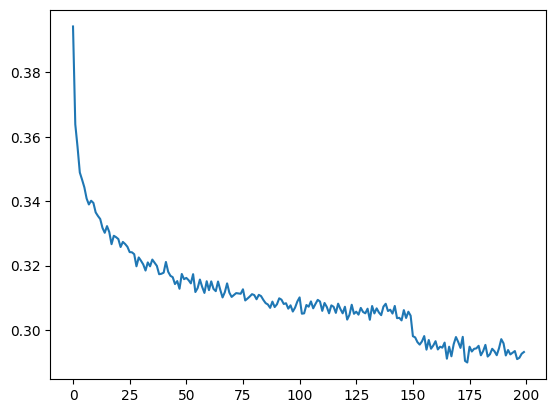

In [ ]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(dim=1))

In [ ]:
for layer in model.layers:
  layer.training = False

In [ ]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9097388982772827
val 2.0178120136260986


In [ ]:
# Sample from the model
for _ in range(40):
  out = []
  context = [0] * block_size # initialize with all ...
  while True:
    # forward pass the neural net
    logits = model(torch.tensor([context]))
    probs = F.softmax(logits, dim=1)
    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1).item()
    # shift the context window and track the samples
    context = context[1:] + [ix]
    out.append(ix)
    # if we sample the special '.' token, break
    if ix == 0:
      break
  print("".join(itos[i] for i in out)) # decode and print the generated word

mykeewo.
dalis.
daken.
olvee.
wohdenn.
natdor.
kroselynn.
hers.
shlevan.
mykelin.
chimari.
roben.
gandris.
kiahne.
emorge.
adrywar.
loman.
mecki.
vanner.
sheriya.
aaree.
marletca.
anna.
zayla.
adiel.
byena.
dezolee.
chynori.
tykel.
tarier.
sorah.
briem.
anny.
lornito.
atham.
lega.
julii.
shakodi.
zulyah.
mylaiya.


In [ ]:
# batch norm fix

In [ ]:
e = torch.randn(32, 4, 68)
emean = e.mean((0, 1), keepdim=True) # 1, 1, 68
evar = e.var((0, 1), keepdim=True) # 1, 1, 68
ehat = (e - emean) / torch.sqrt(evar + 1e-5) # 32, 4, 68
ehat.shape

torch.Size([32, 4, 68])

In [ ]:
emean.shape

torch.Size([1, 1, 68])

In [ ]:
model.layers[3].running_mean.shape

torch.Size([1, 4, 68])

In [ ]:
# Convolutions

In [ ]:
for x, y in zip(Xtr[7:15], Ytr[7:15]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .


In [ ]:
# forward a single example:
logits = model(Xtr[[7]])
logits.shape

torch.Size([1, 27])

In [ ]:
# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
  logits[i] = model(Xtr[[7 + i]])
logits.shape

torch.Size([8, 27])